In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import warnings
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

In [ ]:
# download nltk word
# nltk.download("wordnet", "./nltk_data/")
# nltk.download('omw-1.4', "./nltk_data/")
# nltk.download('punkt', "./nltk_data/")
# nltk.download('averaged_perceptron_tagger', "./nltk_data/")
# nltk.download('stopwords', "./nltk_data/")
nltk.data.path.append('./nltk_data')

# 0. import data

In [3]:

training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")

In [4]:
# view data
training_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
training_data.sample(2)

,id,keyword,location,text,target
6052,8650,sinkhole,"Haddonfield, NJ",Sinkhole closes Falmer Drive in Bethlehem Town...,1
6522,9329,survive,EveryWhere,:: Survive??,0


In [12]:
training_data.loc[[5085, 6318]]

,id,keyword,location,text,target
5085,7252,nuclear%20disaster,The Netherlands,?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaste...,1
6318,9030,stretcher,??,Stretcher in 5 min // Speaker Deck http://t.co...,0


# 1. Data Cleaning

In [14]:
# to lowercase
training_data['cleaned_text'] = training_data['text'].apply(lambda x:x.lower())

In [16]:
training_data.head(2)


,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada


In [17]:
# Stemming and Lemmatization
# Often we want to map the different forms of the same word to the same root word, 
# e.g. "walks", "walking", "walked" should all be the same as "walk".
#
# The stemming and lemmatization process are hand-written regex rules written find the root word.
#
# Stemming: Trying to shorten a word with simple regex rules
#
# Lemmatization: Trying to find the root word with linguistics rules (with the use of regexes)
#
# (See also: Stemmers vs Lemmatizers question on StackOverflow)
#
# There are various stemmers and one lemmatizer in NLTK, the most common being:
#
# Porter Stemmer from Porter (1980)
# Wordnet Lemmatizer (port of the Morphy: https://wordnet.princeton.edu/man/morphy.7WN.html)
# wnler =WordNetLemmatizer()
porter = PorterStemmer()

In [18]:
for word in ['driving', 'drives', 'drove','driver']:
    print(porter.stem(word))

drive
drive
drove
driver


In [39]:
def find_stem_word(x):
    words = []
    for wordi in x.split(' '):
        words.append(porter.stem(wordi))
    return " ".join(words)

In [46]:
find_stem_word("The U.S. bombed Hiroshima 70 years ago today.") # years -> year

'the u.s. bomb hiroshima 70 year ago today.'

In [40]:
training_data['cleaned_text'] = training_data['text'].apply(find_stem_word)

In [45]:
training_data.sample(2)

,id,keyword,location,text,target,cleaned_text
1096,1585,bombed,New York,The U.S. bombed Hiroshima 70 years ago today. ...,1,the u.s. bomb hiroshima 70 year ago today. a l...
6070,8670,sinkhole,hell,i could die by falling in a sinkhole and i'd s...,0,i could die by fall in a sinkhol and i'd still...


## Remove StopWords
Stop words are frequently used words that carry very little meaning.
Stop words are words that are so common they are basically ignored by typical tokenizer.
By default, NLTK (Natural Language Toolkit) includes a list of 40 stop words, including: "a", "an", "the", "of", "in", and so on..

In [24]:
stop_words = stopwords.words("english")
stop_words[88:99]

['up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then']

In [25]:
def remove_stopwords(texts):
    nun_stop_words = []
    for w in texts.split(' '):
        if w not in stop_words:
            nun_stop_words.append(w)
    return " ".join(nun_stop_words)

In [48]:
training_data['cleaned_text'] = training_data['cleaned_text'].apply(remove_stopwords)

In [49]:
training_data.sample(2)

,id,keyword,location,text,target,cleaned_text
530,770,avalanche,South Central Wales,I saw two great punk bands making original mus...,0,saw two great punk band make origin music last...
3158,4533,emergency,Sacae Plains,in BOTH 'peacetime and times of national emerg...,1,'peacetim time nation emergency.'


In [50]:
# Remove unwanted text- Text Cleaning nonsense words like url, https:// #
def remove_nonsense(x):
    x = re.sub(r'^RT[\s]+', '', x)
    x = re.sub(r'https?://[^\s\n\r]+', '', x)
    x = re.sub(r'#', '', x)
    return x


In [51]:
training_data['cleaned_text'] = training_data['cleaned_text'].apply(remove_nonsense)


In [52]:
training_data.loc[[5085, 6318]]

,id,keyword,location,text,target,cleaned_text
5085,7252,nuclear%20disaster,The Netherlands,?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaste...,1,?fukushima?tepco?\nfukushima nuclear disast | ...
6318,9030,stretcher,??,Stretcher in 5 min // Speaker Deck http://t.co...,0,stretcher 5 min // speaker deck


In [53]:
def remove_punctuation(x):
    return re.sub(r'[^a-zA-Z0-9]', ' ', x)


In [54]:
training_data['cleaned_text'] = training_data['cleaned_text'].apply(remove_punctuation)


In [55]:
training_data.loc[[5085, 6318]]

,id,keyword,location,text,target,cleaned_text
5085,7252,nuclear%20disaster,The Netherlands,?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaste...,1,fukushima tepco fukushima nuclear disast i...
6318,9030,stretcher,??,Stretcher in 5 min // Speaker Deck http://t.co...,0,stretcher 5 min speaker deck


## Data visualization


In [43]:
training_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            7613 non-null   int64 
 1   keyword       7552 non-null   object
 2   location      5080 non-null   object
 3   text          7613 non-null   object
 4   target        7613 non-null   int64 
 5   cleaned_text  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


In [65]:
training_data.isnull().sum()

id                 0
keyword           61
location        2533
text               0
target             0
cleaned_text       0
dtype: int64

In [75]:
data_null_values = list(training_data.isnull().sum().values)
data_null_keys = list(training_data.isnull().sum().keys())

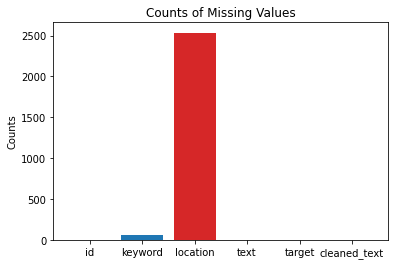

In [93]:
fig_data_null, ax_data_null = plt.subplots()

columns = data_null_keys
counts = data_null_values
bar_labels = ['red', 'blue']

ax_data_null.bar(columns, counts,  color=bar_colors)

ax_data_null.set_ylabel('Counts')
ax_data_null.set_title('Counts of Missing Values')

plt.show()


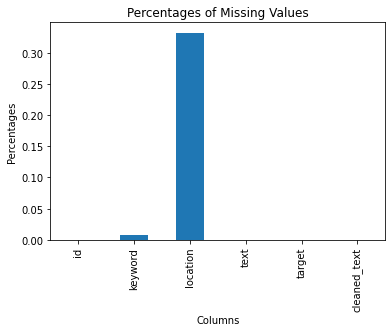

In [47]:
(training_data.isnull().sum() / len(training_data)).plot(kind='bar')
plt.ylabel('Percentages')
plt.xlabel('Columns')
plt.title('Percentages of Missing Values')
plt.show()


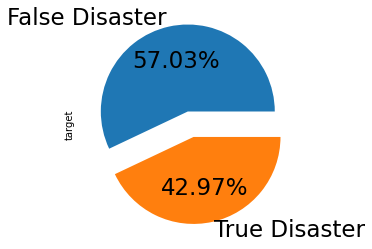

In [95]:
training_data['target'].value_counts().plot.pie(explode = [0.15, 0.15],
                                        labels =  ['False Disaster', 'True Disaster'],
                                        # shadow = True,
                                        autopct = '%2.2f%%',
                                        textprops = {'fontsize' : 23 })
plt.show();

In [96]:
training_data['keyword'].value_counts()[0:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

In [97]:
top_10_false_disaster = training_data[training_data['target'] == 0]['keyword'].value_counts()[0:10]
top_10_false_disaster

body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
Name: keyword, dtype: int64

In [98]:
top_10_kw_true_disaster = training_data[training_data['target'] == 1]['keyword'].value_counts()[0:10]
top_10_kw_true_disaster

derailment           39
wreckage             39
outbreak             39
debris               37
oil%20spill          37
typhoon              37
evacuated            32
suicide%20bombing    32
rescuers             32
suicide%20bomb       32
Name: keyword, dtype: int64

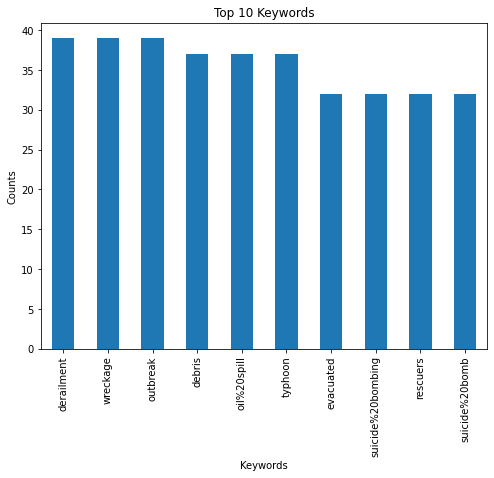

In [109]:
plt.figure(figsize= (8,6))
top_10_kw_true_disaster.plot(kind='bar')
plt.title('Top 10 Keywords')
plt.xlabel('Keywords')
plt.ylabel('Counts')
plt.show();


In [110]:
top_10_loc_true_disaster = training_data[training_data['target'] == 1]['location'].value_counts()[0:10]
top_10_loc_true_disaster

USA               67
United States     27
Nigeria           22
India             20
Mumbai            19
UK                16
London            16
New York          16
Washington, DC    15
Canada            13
Name: location, dtype: int64

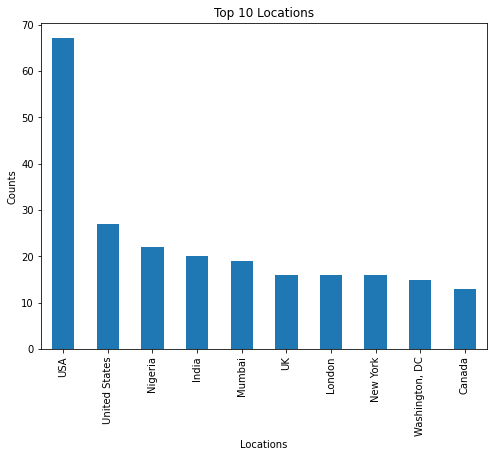

In [162]:
plt.figure(figsize= (8,6))
top_10_loc_true_disaster.plot(kind='bar')
plt.title('Top 10 Locations')
plt.xlabel('Locations')
plt.ylabel('Counts')
plt.show();


In [239]:
import urllib
def parse_to_str(list_str):
    return [urllib.parse.unquote(i) for i in list_str]

In [ ]:
# Generate a word cloud image
mask = training_data['location'].notnull() & training_data['target'] == 1
text = ",, ".join(list(training_data[mask]['location'].values))
wordcloud = WordCloud(width = 1920, height = 1080, 
                      background_color='white', colormap='Set2', 
                      collocations=False, stopwords = {',, '},).generate(text)

plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");


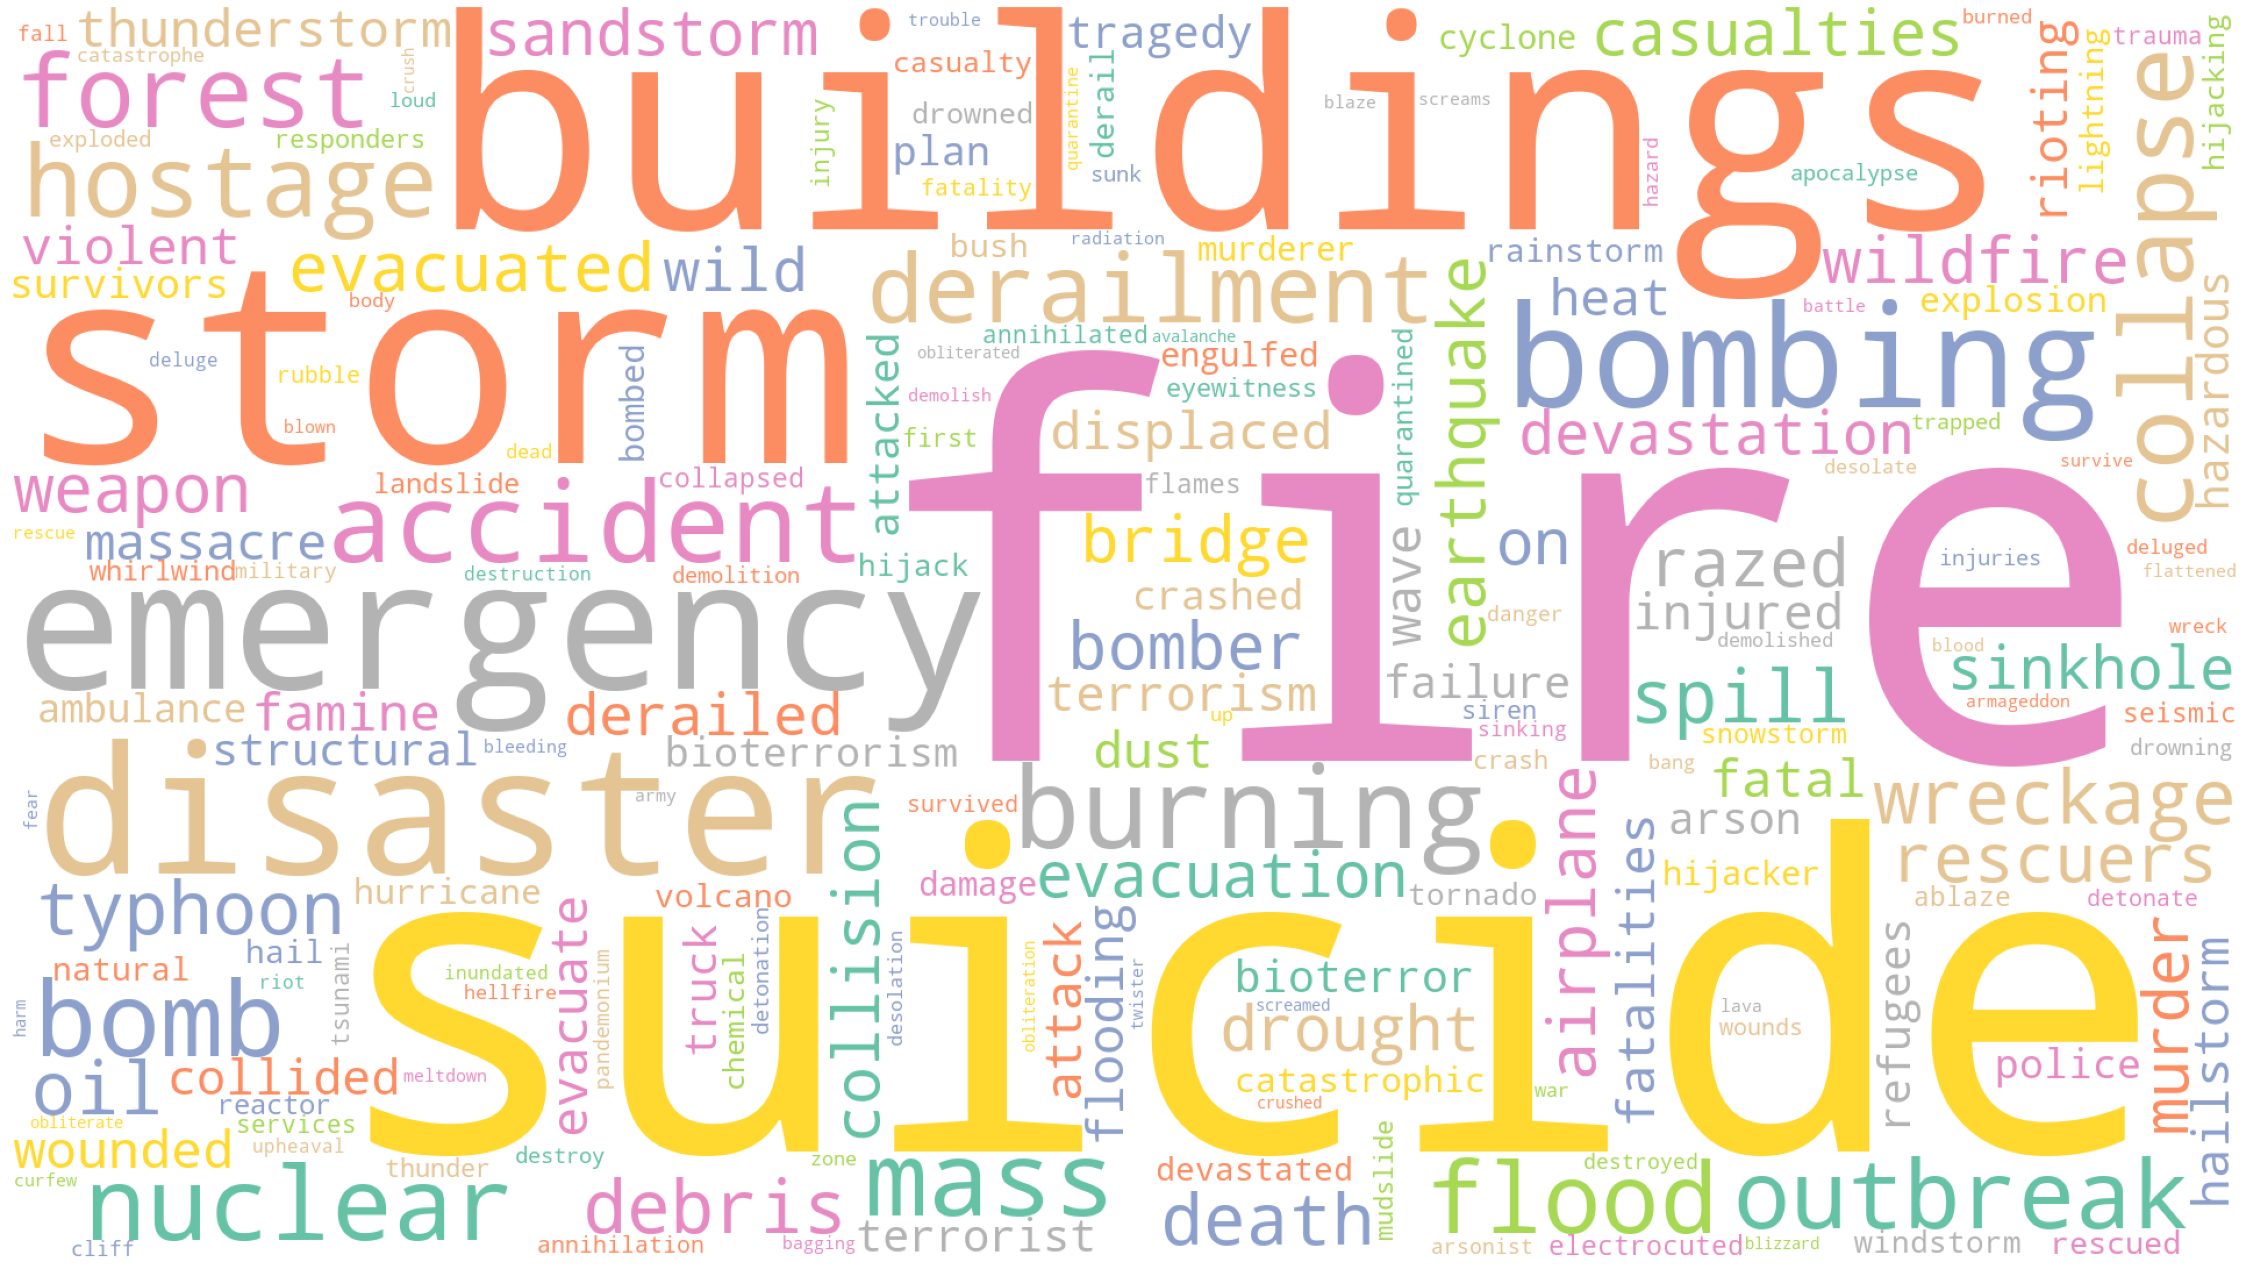

In [241]:
# Generate a word cloud image
mask = training_data['keyword'].notnull() & training_data['target'] == 1
text_list = parse_to_str(list(training_data[mask]['keyword'].values))
text = ",, ".join(text_list)
wordcloud = WordCloud(width = 1920, height = 1080, 
                      background_color='white', colormap='Set2', 
                      collocations=False,stopwords = {',, '}).generate(text)

plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");


In [243]:
# dump the new_train to csv
# training_data.to_csv('./new_tran.csv')

## Clustering Algorithm
### todo